<a href="https://colab.research.google.com/github/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Recommender_System_using_Softmax_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
# from keras.models import Model
# from keras.layers import Input, Reshape, Dot
# from keras.layers.embeddings import Embedding
# from keras.optimizers import Adam
# from keras.regularizers import l2
# from keras.layers import Concatenate, Dense, Dropout
# from keras.layers import Add, Activation, Lambda

import tensorflow as tf
import keras
from pprint import pprint

In [3]:
# DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [4]:
# !wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip -n ml-100k.zip

#Loading MovieLens dataset

## Loading Courses

In [103]:
items_dataset = pd.read_excel('../Documents/Bachelor/Rated_Courses.xlsx')
items_dataset = items_dataset.drop('Unnamed: 0',axis=1)
items_dataset['id'] = items_dataset['id'].astype(int)
items_dataset.head()

,id,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min,published_time,last_update_date,category,subcategory,topic,language,course_url,instructor_name,instructor_url
0,638418,DSLR Video For Beginners,True,19.99,Learn the skills to create amazing videos usin...,1291,4.250000,41,13,33,115,2015-10-29T17:34:36Z,2020-10-10,Photography & Video,Video Design,Videography,English,/course/how-to-master-dslr-video-create-a-prof...,Mark Beniston,/user/mark-beniston/
1,3640438,Final Cut Pro (FCP) X broadcast quality Editin...,True,124.99,Learn to edit like a Pro at broadcast quality ...,491,4.916666,127,41,25,317,2020-11-29T14:57:24Z,2020-11-25,Photography & Video,Video Design,Video Editing,English,/course/final-cut-pro-fcp-x-broadcast-quality-...,Dean Arnett,/user/dean-arnett/
2,4439592,Formation videoscribe,True,19.99,Le guide complet pour créer vos animations,3,4.500000,1,1,13,132,2022-02-16T21:52:26Z,2022-02-13,Photography & Video,Video Design,VideoScribe,French,/course/formation-videoscribe-juristudes/,Franklin Lombi Mufuri,/user/franklin-lombi/
3,451966,Improve your WEST freestyle technique- from 20...,True,64.99,Some people feel their out of air? they think ...,153,4.300000,11,5,30,44,2015-03-22T22:20:06Z,2016-03-19,Health & Fitness,Sports,Swimming,English,/course/improve-your-west-freestyle-technique-...,Ori Sela,/user/orisela2/
4,1578238,Fundamentals of Scope and Requirements,True,199.99,Scope and Requirement Management,100,3.850000,24,6,488,302,2018-03-06T16:03:36Z,2021-10-27,Business,Management,Project Planning,English,/course/scope-and-requirements/,Integrity Training,/user/integtrity-training/


In [104]:
encoded_cols = pd.get_dummies(items_dataset['subcategory'], prefix='')
encoded_cols = encoded_cols.rename(columns=lambda x: x.replace('_', ''))
items_dataset = pd.concat([items_dataset, encoded_cols], axis=1)
items_dataset.head()

,id,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,...,Teacher Training,Test Prep,Travel,User Experience Design,Video & Mobile Marketing,Video Design,Vocal,Web Design,Web Development,Yoga
0,638418,DSLR Video For Beginners,True,19.99,Learn the skills to create amazing videos usin...,1291,4.250000,41,13,33,...,0,0,0,0,0,1,0,0,0,0
1,3640438,Final Cut Pro (FCP) X broadcast quality Editin...,True,124.99,Learn to edit like a Pro at broadcast quality ...,491,4.916666,127,41,25,...,0,0,0,0,0,1,0,0,0,0
2,4439592,Formation videoscribe,True,19.99,Le guide complet pour créer vos animations,3,4.500000,1,1,13,...,0,0,0,0,0,1,0,0,0,0
3,451966,Improve your WEST freestyle technique- from 20...,True,64.99,Some people feel their out of air? they think ...,153,4.300000,11,5,30,...,0,0,0,0,0,0,0,0,0,0
4,1578238,Fundamentals of Scope and Requirements,True,199.99,Scope and Requirement Management,100,3.850000,24,6,488,...,0,0,0,0,0,0,0,0,0,0


## Loading User Ratings

In [105]:
## same item id is same as movie id, item id column is renamed as movie id
ratings_dataset = pd.read_excel('../Documents/Bachelor/User_Ratings.xlsx')
ratings_dataset = ratings_dataset.drop('Unnamed: 0',axis=1)
dates = pd.to_datetime(ratings_dataset['timestamp'])
ratings_dataset['timestamp'] = (dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
ratings_dataset.head() 

,userId,courseId,rating,timestamp
0,0,638418,4.5,1646141837
1,0,3640438,4.0,1647343090
2,0,4439592,4.5,1649625733
3,0,451966,5.0,1637992035
4,1,1578238,4.0,1629654452


In [106]:
items_dataset.rename(columns = {'id':'courseId'}, inplace = True)

In [107]:
len(items_dataset.groupby(by='title')),len(items_dataset)

(31037, 34926)

In [108]:
items_dataset.columns

Index(['courseId', 'title', 'is_paid', 'price', 'headline', 'num_subscribers',
       'avg_rating', 'num_reviews', 'num_comments', 'num_lectures',
       ...
       'Teacher Training', 'Test Prep', 'Travel', 'User Experience Design',
       'Video & Mobile Marketing', 'Video Design', 'Vocal', 'Web Design',
       'Web Development', 'Yoga'],
      dtype='object', length=150)

In [109]:
list(['courseId', 'title']) + list(encoded_cols.columns)

['courseId',
 'title',
 '3D & Animation',
 'Accounting & Bookkeeping',
 'Affiliate Marketing',
 'Apple',
 'Architectural Design',
 'Arts & Crafts',
 'Beauty & Makeup',
 'Branding',
 'Business Analytics & Intelligence',
 'Business Law',
 'Business Strategy',
 'Career Development',
 'Commercial Photography',
 'Communication',
 'Compliance',
 'Content Marketing',
 'Creativity',
 'Cryptocurrency & Blockchain',
 'Dance',
 'Data Science',
 'Database Design & Development',
 'Design Tools',
 'Digital Marketing',
 'Digital Photography',
 'E-Commerce',
 'Economics',
 'Engineering',
 'Entrepreneurship',
 'Esoteric Practices',
 'Fashion Design',
 'Finance',
 'Finance Cert & Exam Prep',
 'Financial Modeling & Analysis',
 'Fitness',
 'Food & Beverage',
 'Game Design',
 'Game Development',
 'Gaming',
 'General Health',
 'Google',
 'Graphic Design & Illustration',
 'Growth Hacking',
 'Happiness',
 'Hardware',
 'Home Improvement & Gardening',
 'Human Resources',
 'Humanities',
 'IT Certifications',
 'I

In [110]:
course_dataset = items_dataset[list(['courseId', 'title']) + list(encoded_cols.columns)]
course_dataset.head()

,courseId,title,3D & Animation,Accounting & Bookkeeping,Affiliate Marketing,Apple,Architectural Design,Arts & Crafts,Beauty & Makeup,Branding,...,Teacher Training,Test Prep,Travel,User Experience Design,Video & Mobile Marketing,Video Design,Vocal,Web Design,Web Development,Yoga
0,638418,DSLR Video For Beginners,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3640438,Final Cut Pro (FCP) X broadcast quality Editin...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4439592,Formation videoscribe,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,451966,Improve your WEST freestyle technique- from 20...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1578238,Fundamentals of Scope and Requirements,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column

In [111]:
## looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
# len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

We can see there are 18 extra movie id's for already mapped movie title and the same duplicate movie id is assigned to the user in the user-item dataset.

#Merging required datasets

In [112]:
refined_dataset = pd.merge(ratings_dataset, movie_dataset, how='left', on='courseId').drop_duplicates()
refined_dataset.head()

,userId,courseId,rating,timestamp,title,3D & Animation,Accounting & Bookkeeping,Affiliate Marketing,Apple,Architectural Design,...,Teacher Training,Test Prep,Travel,User Experience Design,Video & Mobile Marketing,Video Design,Vocal,Web Design,Web Development,Yoga
0,0,638418,4.5,1646141837,DSLR Video For Beginners,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,3640438,4.0,1647343090,Final Cut Pro (FCP) X broadcast quality Editin...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,4439592,4.5,1649625733,Formation videoscribe,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,451966,5.0,1637992035,Improve your WEST freestyle technique- from 20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1578238,4.0,1629654452,Fundamentals of Scope and Requirements,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
# merged_dataset = merged_dataset[merged_dataset['user id'] != 777].append(merged_dataset[merged_dataset['user id'] == 777][merged_dataset[merged_dataset['user id'] == 777]['movie id'] == 1], ignore_index=True)

A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

## Creating a final refined dataset with unique user id, movie name combination and their ratings:


## Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks.

In [114]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['userId'].values)
n_users = refined_dataset['user'].nunique()

In [116]:
item_enc = LabelEncoder()
refined_dataset['course'] = item_enc.fit_transform(refined_dataset['title'].values)
n_movies = refined_dataset['course'].nunique()

In [117]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(10000, 31037, 3.0, 5.0)

In [118]:
refined_dataset.head()

,userId,courseId,rating,timestamp,title,3D & Animation,Accounting & Bookkeeping,Affiliate Marketing,Apple,Architectural Design,...,Travel,User Experience Design,Video & Mobile Marketing,Video Design,Vocal,Web Design,Web Development,Yoga,user,course
0,0,638418,4.5,1646141837,DSLR Video For Beginners,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,8005
3,0,3640438,4.0,1647343090,Final Cut Pro (FCP) X broadcast quality Editin...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,10635
5,0,4439592,4.5,1649625733,Formation videoscribe,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11044
6,0,451966,5.0,1637992035,Improve your WEST freestyle technique- from 20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14113
7,1,1578238,4.0,1629654452,Fundamentals of Scope and Requirements,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11366


## Splitting the data into training and testing

In [127]:
X = refined_dataset[list(['user','course','timestamp']) + list(encoded_cols.columns)].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31433, 133), (3493, 133), (31433,), (3493,))

## Defining number of factors which are to be considered by the Embedding layer

In [130]:
n_factors = 150

Columns in the input array are split into two separate arrays. As Keras considers them as two distinct inputs, each input needs to be fed in as its own array.

In [131]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [132]:
X_train, X_train_array, X_train_array[0].shape

(array([[      5633,      29525, 1638174093, ...,          0,          0,
                  0],
        [      4210,      19291, 1634395599, ...,          0,          0,
                  0],
        [      1010,      22399, 1631923105, ...,          0,          0,
                  0],
        ...,
        [      9169,      12965, 1630444781, ...,          0,          0,
                  0],
        [      6490,      15304, 1648277872, ...,          0,          0,
                  0],
        [      4002,      26048, 1643600159, ...,          0,          0,
                  0]], dtype=int64),
 [array([5633, 4210, 1010, ..., 9169, 6490, 4002], dtype=int64),
  array([29525, 19291, 22399, ..., 12965, 15304, 26048], dtype=int64)],
 (31433,))

## Normalizing the labels

In [133]:

y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## Building a Softmax Deep Neural Network

In [134]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [135]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 150)       1500000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       4655550     ['input_2[0][0]']                
                                                                                              

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])


Epoch 1/70
246/246 [==============================] - 13s 50ms/step - loss: 1.4423 - accuracy: 0.0066 - val_loss: 0.9123 - val_accuracy: 0.0063 - lr: 0.0100
Epoch 2/70
246/246 [==============================] - 13s 51ms/step - loss: 0.7724 - accuracy: 0.0065 - val_loss: 0.6729 - val_accuracy: 0.0063 - lr: 0.0100
Epoch 3/70
244/246 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.0064

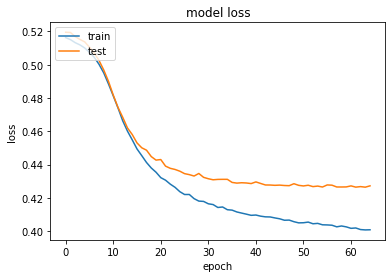

In [29]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Getting movies for given User

In [30]:
refined_dataset.head()

,user id,movie title,rating,movie id,release date,Action,Adventure,Animation,Children,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user,movie
0,1,101 Dalmatians (1996),2.0,225,27-Nov-1996,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,2
1,5,101 Dalmatians (1996),2.0,225,27-Nov-1996,0,0,0,1,1,...,0,0,0,0,0,0,0,0,4,2
2,13,101 Dalmatians (1996),2.0,225,27-Nov-1996,0,0,0,1,1,...,0,0,0,0,0,0,0,0,12,2
3,15,101 Dalmatians (1996),3.0,225,27-Nov-1996,0,0,0,1,1,...,0,0,0,0,0,0,0,0,14,2
4,38,101 Dalmatians (1996),5.0,225,27-Nov-1996,0,0,0,1,1,...,0,0,0,0,0,0,0,0,37,2


**How this DNN model works is, it takes two inputs, one of the input has user id's and the other has corresponding movie id's. Here DNN model tries to predict the ratings of the user - movie combination. So, we can input a specific user id (broadcasting it with the size of other input) and unseen movie id of the user and expect the model to give the ratings of the movies which would have been the ratings given by the user. Here, the ratings are already normalized and as we need the movies which interest the user more, ratings are not brought back to 0-5 scale.**

In [31]:
X_train_array

[array([ 89, 663, 531, ..., 428,  89, 824], dtype=int64),
 array([1317, 1002,   25, ..., 1297,  940,  563], dtype=int64)]

Above is the model input shape

In [32]:
# merged_dataset = merged_dataset[merged_dataset['user id'] != 777].append(merged_dataset[merged_dataset['user id'] == 777][merged_dataset[merged_dataset['user id'] == 777]['movie id'] == 1], ignore_index=True)

In [71]:

user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[1523]


Id's of movies which are already seen by the user are extracted.

In [34]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(1664, 0, 1663)

We can understand that the labels are from 0 to 1663. So the movie id's which are not seen by the user can be pciked just by excluding the 'seen_movies' list from the first 1663 natural numbers.

In [35]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Movies which are not seen by the user.

In [36]:
len(unseen_movies) + len(seen_movies)

1664

In [37]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 1663)

**DNN model is used to predict the ratings of the unseen movies.**

In [38]:
predicted_ratings = model.predict(model_input)

52/52 [==============================] - 0s 881us/step


In [39]:
print(predicted_ratings.shape)

(1663, 9)


In [40]:
print(predicted_ratings)

[[8.3829504e-01 1.6165373e-01 5.9983845e-06 ... 1.0079749e-05
  4.5824445e-06 8.2036686e-06]
 [7.4217570e-01 2.5775754e-01 8.5935599e-06 ... 1.3144391e-05
  6.5230938e-06 9.0167241e-06]
 [8.6257923e-01 1.3734631e-01 9.8406954e-06 ... 1.5503039e-05
  6.7358992e-06 1.1419675e-05]
 ...
 [8.2174748e-01 1.7819013e-01 7.9432684e-06 ... 1.2495490e-05
  5.8175528e-06 9.2858163e-06]
 [6.9526112e-01 3.0465120e-01 1.1021787e-05 ... 1.6597292e-05
  8.5353695e-06 1.2141368e-05]
 [7.3373246e-01 2.6620218e-01 8.1411681e-06 ... 1.2483725e-05
  6.1441333e-06 9.0209960e-06]]


Output is of shape (1628, 9). We got probability of each possible rating from 1 to 5. We can extract specific rating which user would have given to a movie but it is not useful for these recommendations now.

In [41]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

array([0.83829504, 0.7421757 , 0.8625792 , ..., 0.8217475 , 0.6952611 ,
       0.73373246], dtype=float32)

In [42]:
predicted_ratings.shape

(1663,)

Index of ratings sorted by descending order.

In [43]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[ 982 1478  481 ... 1172 1124   27]


**Movie names have been extracted from the available indices we got.**

In [44]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Mimic (1997)', 'Thinner (1996)', 'Extreme Measures (1996)', ...,
       'Prefontaine (1997)', 'Paris Is Burning (1990)',
       'African Queen, The (1951)'], dtype=object)

## Movies recommended with the help of Softmax Deep Neural Networks

In [55]:
len(recommended_movies)

1663

In [66]:
items_dataset[items_dataset['movie id']==1523]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1522,1523,"Good Man in Africa, A (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Good%20Man%20...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
seen_movies

[1523]

In [45]:
items_dataset[items_dataset['movie title'].isin(recommended_movies)]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
from pprint import pprint
pprint(list(recommended_movies[:20]))

['Mimic (1997)',
 'Thinner (1996)',
 'Extreme Measures (1996)',
 'Beautician and the Beast, The (1997)',
 'Harriet the Spy (1996)',
 'Junior (1994)',
 'Crow: City of Angels, The (1996)',
 'Island of Dr. Moreau, The (1996)',
 'Batman & Robin (1997)',
 'Last Man Standing (1996)',
 'Sgt. Bilko (1996)',
 'Broken Arrow (1996)',
 'Chamber, The (1996)',
 'Jungle2Jungle (1997)',
 'Coneheads (1993)',
 'Wrong Trousers, The (1993)',
 'Robin Hood: Men in Tights (1993)',
 'Space Jam (1996)',
 'Visitors, The (Visiteurs, Les) (1993)',
 'Juror, The (1996)']


## Summing up the entire code into a recommender system function:

In [58]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))
  return list(recommended_movies[:n_movies])


In [59]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id
777
Enter number of movies to be recommended:
15

Movie seen by the User:
['Toy Story (1995)']

52/52 [==============================] - 0s 894us/step
---------------------------------------------------------------------------------
Top 15 Movie recommendations for the User 777 are:
['Mimic (1997)',
 'Thinner (1996)',
 'Extreme Measures (1996)',
 'Beautician and the Beast, The (1997)',
 'Harriet the Spy (1996)',
 'Junior (1994)',
 'Crow: City of Angels, The (1996)',
 'Island of Dr. Moreau, The (1996)',
 'Batman & Robin (1997)',
 'Last Man Standing (1996)',
 'Sgt. Bilko (1996)',
 'Broken Arrow (1996)',
 'Chamber, The (1996)',
 'Jungle2Jungle (1997)',
 'Coneheads (1993)']


['Mimic (1997)',
 'Thinner (1996)',
 'Extreme Measures (1996)',
 'Beautician and the Beast, The (1997)',
 'Harriet the Spy (1996)',
 'Junior (1994)',
 'Crow: City of Angels, The (1996)',
 'Island of Dr. Moreau, The (1996)',
 'Batman & Robin (1997)',
 'Last Man Standing (1996)',
 'Sgt. Bilko (1996)',
 'Broken Arrow (1996)',
 'Chamber, The (1996)',
 'Jungle2Jungle (1997)',
 'Coneheads (1993)']

In [60]:
items_dataset[items_dataset['movie title'].isin(recommender_system(user_id,model,n_movies))]


Movie seen by the User:
['Toy Story (1995)']

52/52 [==============================] - 0s 926us/step
---------------------------------------------------------------------------------
Top 15 Movie recommendations for the User 777 are:
['Mimic (1997)',
 'Thinner (1996)',
 'Extreme Measures (1996)',
 'Beautician and the Beast, The (1997)',
 'Harriet the Spy (1996)',
 'Junior (1994)',
 'Crow: City of Angels, The (1996)',
 'Island of Dr. Moreau, The (1996)',
 'Batman & Robin (1997)',
 'Last Man Standing (1996)',
 'Sgt. Bilko (1996)',
 'Broken Arrow (1996)',
 'Chamber, The (1996)',
 'Jungle2Jungle (1997)',
 'Coneheads (1993)']


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
104,105,Sgt. Bilko (1996),29-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Sgt.%20Bilko%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,243,Jungle2Jungle (1997),07-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Jungle2Jungle...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
253,254,Batman & Robin (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Batman+%26+Ro...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
263,264,Mimic (1997),22-Aug-1997,NaN,http://us.imdb.com/M/title-exact?Mimic+(1997),0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
405,406,Thinner (1996),25-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Thinner%20(1996),0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
545,546,Broken Arrow (1996),09-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Broken%20Arro...,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
576,577,Coneheads (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Coneheads%20(...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
618,619,Extreme Measures (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Extreme%20Mea...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
619,620,"Chamber, The (1996)",11-Oct-1996,NaN,"http://us.imdb.com/M/title-exact?Chamber,%20Th...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
727,728,Junior (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Junior%20(1994),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [64]:
merged_dataset[merged_dataset['user id'] == 777]

,user id,movie id,rating,timestamp,movie title,release date,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
99964,777,1,4,875979431,Toy Story (1995),01-Jan-1995,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


# Rough Work

In [49]:
a = np.asarray([[2,3,14,6],[3,5,7,2],[6,8,4,1]])
a, a.shape

(array([[ 2,  3, 14,  6],
        [ 3,  5,  7,  2],
        [ 6,  8,  4,  1]]),
 (3, 4))

In [50]:
b=np.max(a, axis=1)
b, b.shape

(array([14,  7,  8]), (3,))

In [51]:
np.argsort(b)[::-1]

array([0, 2, 1], dtype=int64)

In [52]:

user_enc.transform([1])

array([0], dtype=int64)

In [53]:
max(refined_dataset['user'])

942